<a href="https://colab.research.google.com/github/van-dang/MRI-Cloud/blob/master/StrongPeriodicBC_OneComp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# About the solver

In [0]:
# This demo solves the transformed Bloch-Torrey equation applied to diffusion MRI 
# using the standard finite element method coupled with the theta-method 
# for the space discretization.

# This demo allows a single domain with periodic boundaries and the spins can
# enter and exit the computational domain freely by using the periodic boundary
# conditions

# Copyright (C) 2017 Van-Dang Nguyen

# This file is part of DOLFIN.

# DOLFIN is free software: you can redistribute it and/or modify
# it under the terms of the GNU Lesser General Public License as published by
# the Free Software Foundation, either version 3 of the License, or
# (at your option) any later version.

# DOLFIN is distributed in the hope that it will be useful,
# but WITHOUT ANY WARRANTY; without even the implied warranty of
# MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. See the
# GNU Lesser General Public License for more details.

# You should have received a copy of the GNU Lesser General Public License
# along with DOLFIN. If not, see <http://www.gnu.org/licenses/>.

# First added:  2017-10-10
# Last changed: 2019-04-10

# Setting a working environment

In [72]:
from google.colab import files

import platform, sys
python_version=platform.python_version()
from distutils.version import LooseVersion, StrictVersion

if ( LooseVersion(python_version) < LooseVersion("3.0.0")):
    print("Python3 is needed!");
    print("How to fix: Runtime/Change_runtime_type/Python 3");
    sys.exit()
    
try:
    from dolfin import *; from mshr import *
except ImportError as e:
    !apt-get install -y -qq software-properties-common python-software-properties module-init-tools
    !add-apt-repository -y ppa:fenics-packages/fenics
    !apt-get update -qq
    !apt install -y --no-install-recommends fenics
    from dolfin import *; from mshr import *
    
import matplotlib.pyplot as plt;
from IPython.display import clear_output, display; import time; import dolfin.common.plotting as fenicsplot 
import time

import os, sys, shutil

dolfin_version = dolfin.__version__
print ('dolfin version:', dolfin_version)

!rm -rf * # clean up all files

dolfin version: 2018.1.0


# Generate a periodic mesh

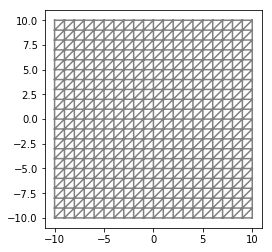

In [73]:
xmin, ymin, xmax, ymax = -10, -10, 10, 10
nx, ny = 20, 20;
factor = 1;
mesh = RectangleMesh(Point(xmin, ymin), Point(xmax, ymax), factor*nx, factor*ny, "right")

plot(mesh)

tol = 1e-6*mesh.hmin();
class PeriodicBD100(SubDomain):
    # Left boundary is "target domain" G
    def inside(self, x, on_boundary):
        return bool(x[0] < xmin + tol and x[0] > xmin - tol and on_boundary)

    # Map right boundary (H) to left boundary (G)
    def map(self, x, y):
        y[0] = x[0] - (xmax-xmin)
        y[1] = x[1]
        y[2] = x[2]
        
class PeriodicBD010(SubDomain):
    # Left boundary is "target domain" G
    def inside(self, x, on_boundary):
        return bool(x[1] < ymin + tol and x[1] > ymin - tol and on_boundary)

    # Map right boundary (H) to left boundary (G)
    def map(self, x, y):
        y[0] = x[0] 
        y[1] = x[1] - (ymax-ymin)
        y[2] = x[2] 

     

In [0]:
pbc100 = PeriodicBD100()
pbc010 = PeriodicBD010()
def MyFunctionSpaces(mesh, porder):
  Ve = FiniteElement("CG", mesh.ufl_cell(), porder)
  V = FunctionSpace(mesh,Ve)
  TH = MixedElement([Ve,Ve])
  W = FunctionSpace(mesh, TH, constrained_domain=pbc010)
  return V, W

V, W = MyFunctionSpaces(mesh, 1)

t=0.000000  gnorm: 0.000005 ift: 0.000000 ft: 1.000000
t=4000.000000  gnorm: 0.000005 ift: 4000.000000 ft: 1.000000
t=8000.000000  gnorm: 0.000005 ift: 8000.000000 ft: 1.000000
t=12000.000000  gnorm: 0.000005 ift: 12000.000000 ft: 1.000000
t=16000.000000  gnorm: 0.000005 ift: 16000.000000 ft: 1.000000
t=20000.000000  gnorm: 0.000005 ift: 20000.000000 ft: 1.000000
t=24000.000000  gnorm: 0.000005 ift: 24000.000000 ft: 1.000000
t=28000.000000  gnorm: 0.000005 ift: 28000.000000 ft: 1.000000
t=32000.000000  gnorm: 0.000005 ift: 32000.000000 ft: 1.000000
t=36000.000000  gnorm: 0.000005 ift: 36000.000000 ft: 1.000000
t=40000.000000  gnorm: 0.000005 ift: 40000.000000 ft: 1.000000
t=44000.000000  gnorm: 0.000005 ift: 44000.000000 ft: 1.000000
t=48000.000000  gnorm: 0.000005 ift: 48000.000000 ft: 1.000000
t=52000.000000  gnorm: 0.000005 ift: 48000.000000 ft: -1.000000
t=56000.000000  gnorm: 0.000005 ift: 44000.000000 ft: -1.000000
t=60000.000000  gnorm: 0.000005 ift: 40000.000000 ft: -1.000000
t

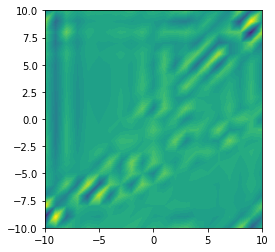

In [75]:
dolfin_version = dolfin.__version__

# parameters
#####################################################################################################################
#####################################################################################################################
porder = 1;
delta, Delta = 50000, 50000
t, T = 0, Delta+delta;
K0, K1 = 3e-3, 3e-3;
g0, g1 = 0.0, 1.0
nskip = 2;
bvalue = 2000;
gnorm = sqrt(bvalue)/sqrt(delta*delta*(Delta-delta/3.0));
#####################################################################################################################
#####################################################################################################################
# Sub domain for Periodic boundary condition

'''
# FUNCTION SPACES
Ve = FiniteElement("CG", mesh.ufl_cell(), 1)
V = FunctionSpace(mesh,Ve);
TH = MixedElement([Ve,Ve])
W = FunctionSpace(mesh, TH, constrained_domain=PeriodicBoundary())
'''

v = TestFunction(W)
v1r, v1i = v[0], v[1]

u = TrialFunction(W);
u1r, u1i = u[0], u[1]
#####################################################################################################################
#####################################################################################################################
# Initial conditions
Dirac_Delta = Expression("x[0]*x[0]+x[1]*x[1]<eps",eps=1e6, domain=mesh, degree=3);
Dirac_Delta = interpolate(Dirac_Delta, V);

File("Dirac.pvd")<<Dirac_Delta;

one = Function(V);
one.vector()[:] = 1.0;

u_0 = Function(W);
assign(u_0.sub(0), one)
u1r_0, u1i_0 = split(u_0)

#####################################################################################################################
#####################################################################################################################

g = Expression(("g0","g1"), g0=g0, g1=g1,domain=mesh,degree=3);

#####################################################################################################################
#####################################################################################################################
def FT(t, delta, Delta):
    ft1 = 1.0*(t>=0 and t<delta) 
    ft2 = -1.0*(t>=Delta and t<=Delta+delta);
    return ft1 + ft2;  

def iFT(t, delta, Delta): # integrate ft
    ft1 = t*(t>=0 and t<delta) 
    ft2 = delta*(t>=delta and t<Delta) 
    ft3 = (delta - t + Delta)*(t>=Delta and t<=Delta+delta) 
    return ft1 + ft2 + ft3;  

stepcounter = 0;
####################################################################################################################
####################################################################################################################
def FuncF(ift, gnorm, g, ur, ui, vr, vi, K):
    Fr =   ift*gnorm*(inner(g,K*grad(ui))+inner(grad(ui),K*g))*vr - inner(g,K*g)*gnorm*gnorm*ift*ift*ur*vr-K*inner(grad(ur), grad(vr))
    Fi = - ift*gnorm*(inner(g,K*grad(ur))+inner(grad(ur),K*g))*vi - inner(g,K*g)*gnorm*gnorm*ift*ift*ui*vi-K*inner(grad(ui), grad(vi))
    return Fr + Fi

def outer_interface(ift, gnorm, K, n, ur, ui, vr, vi, g):
    F_bcr =  (ift*gnorm+1e-16)*inner(K*g, n)*ui*vr 
    F_bci = -(ift*gnorm+1e-16)*inner(K*g, n)*ur*vi
    return F_bcr + F_bci

def ThetaMethod_L(ift, gnorm, g, u1r, u1i, v1r, v1i, u1r_0, u1i_0,k,  K1, theta, n):
    L1 = (u1r_0/k*v1r + u1i_0/k*v1i +theta*FuncF(ift, gnorm, g, u1r_0, u1i_0, v1r, v1i, K1))*dx
    L1_outer_bc = -theta*outer_interface(ift, gnorm, K1, n, u1r_0, u1i_0, v1r, v1i, g)*ds
    return L1 + L1_outer_bc


def ThetaMethod_a(ift, gnorm, g, u1r, u1i, v1r, v1i, u1r_0, u1i_0,k, K1, theta, n):
    a1 = (u1r/k*v1r   + u1i/k*v1i  -theta*FuncF(ift, gnorm, g, u1r  , u1i  , v1r, v1i, K1))*dx
    a1_outer_bc = theta*outer_interface(ift, gnorm ,K1, n, u1r, u1i, v1r, v1i, g)*ds
    return a1 + a1_outer_bc

#############################################################################################################################
#############################################################################################################################
# Theta method

stepcounter = 0;
theta = 0.5;
Nsteps = 50
k = T/Nsteps;

n = FacetNormal(mesh);
# n = Expression(("1","0"),domain=mesh,degree=1);

ift_prev = iFT(t, delta, Delta);

  
while t < T+k: # Time-stepping loop

    ft = FT(t, delta, Delta);
    ift = iFT(t, delta, Delta);
    
    if stepcounter % nskip == 0:
        print('t=%f '%t, 'gnorm: %f'%gnorm, 'ift: %f'%ift,'ft: %f'%ft);

    L = ThetaMethod_L(ift_prev, gnorm, g, u1r, u1i, v1r, v1i, u1r_0, u1i_0, k, K1, theta, n);
    a = ThetaMethod_a(ift, gnorm, g, u1r, u1i, v1r, v1i, u1r_0, u1i_0, k, K1, theta, n);
    A = assemble(a);
    b = assemble(L);
 
    u = Function(W)
    solve(A,u.vector(),b, "gmres");
    
    u1r_0, u1i_0 = split(u)
    
    # SubMeshSave(u0r_0, u0i_0, file_u0r, file_u0i, mesh0, nskip, stepcounter, dolfin_version);
    # SubMeshSave(u1r_0, u1i_0, file_u1r, file_u1i, mesh1, nskip, stepcounter, dolfin_version);
    ift_prev = ift
    t += k;
    stepcounter += 1;
plot(u1r_0);
signal = assemble((u1r_0)*dx)/assemble(Dirac_Delta*dx);
print('b:',bvalue, 'Signal: %.3e'%signal, 'Exact signal: %.3e'%(exp(-bvalue*K1)))
